# GRAPE for CNOT

In [1]:
# ruff: noqa
import os

os.sys.path.append("../../../..")

In [2]:
# ruff: noqa

"""
Gradient Ascent Pulse Engineering (GRAPE)
"""

import jax.numpy as jnp
import sys

from feedback_grape.grape import optimize_pulse, plot_control_amplitudes
from feedback_grape.utils.gates import cnot
from feedback_grape.utils.operators import identity, sigmax, sigmay, sigmaz
from feedback_grape.utils.tensor import tensor

# Example usage
g = 0  # Small coupling strength
H_drift = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
H_ctrl = [
    tensor(sigmax(), identity(2)),
    tensor(sigmay(), identity(2)),
    tensor(sigmaz(), identity(2)),
    tensor(identity(2), sigmax()),
    tensor(identity(2), sigmay()),
    tensor(identity(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz()),
]

U_0 = identity(4)
# Target operator (CNOT gate)
C_target = cnot()

num_t_slots = 500
total_evo_time = 2 * jnp.pi

# Run optimization
result = optimize_pulse(
    H_drift,
    H_ctrl,
    U_0,
    C_target,
    num_t_slots,
    total_evo_time,
    ctrl_amp_lower_bound=-2 * jnp.pi,
    ctrl_amp_upper_bound=2 * jnp.pi,
    evo_type="unitary",
    max_iter=100,
    learning_rate=1e-2,
    optimizer="l-bfgs",
)
print("final_fidelity: ", result.final_fidelity)
print("U_f \n", result.final_operator)
print("Converged after: ", result.iterations)

final_fidelity:  0.9999999999944535
U_f 
 [[ 7.07107075e-01-7.07106488e-01j  1.00006315e-06+1.95732784e-06j
  -1.12166257e-06-2.57763475e-07j  2.25376630e-07-1.42525656e-07j]
 [ 1.95733064e-06+1.00006011e-06j  7.07105154e-01-7.07108408e-01j
  -1.25047473e-08+8.58742942e-07j -2.15112058e-07-4.96347076e-07j]
 [-1.42525404e-07+2.25375555e-07j -4.96348030e-07-2.15111548e-07j
  -1.77568806e-08+4.59500747e-07j  7.07107433e-01-7.07106129e-01j]
 [-2.57761439e-07-1.12166111e-06j  8.58745342e-07-1.25059010e-08j
   7.07107463e-01-7.07106099e-01j  4.59500944e-07-1.77567543e-08j]]
Converged after:  76


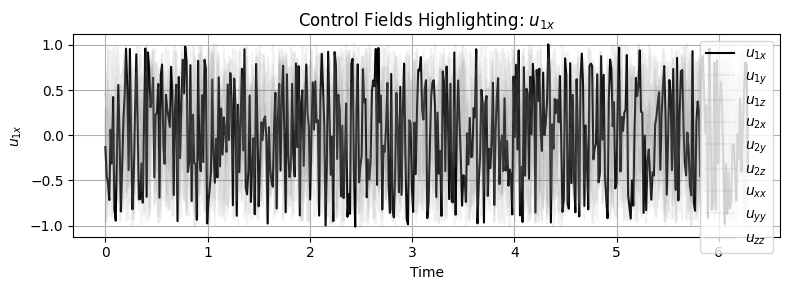

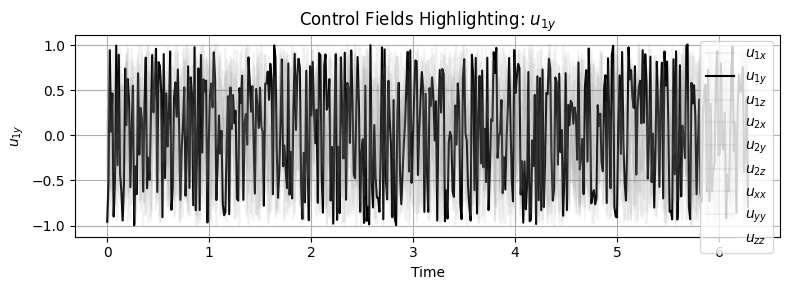

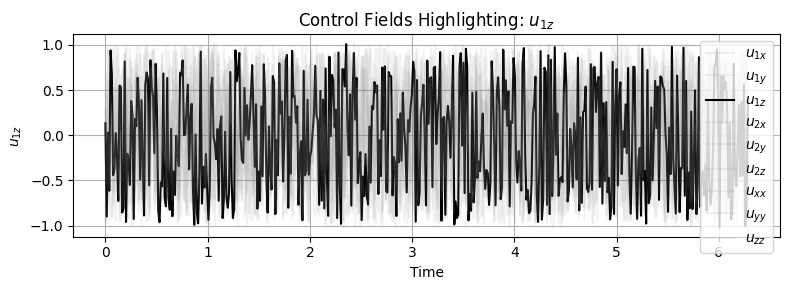

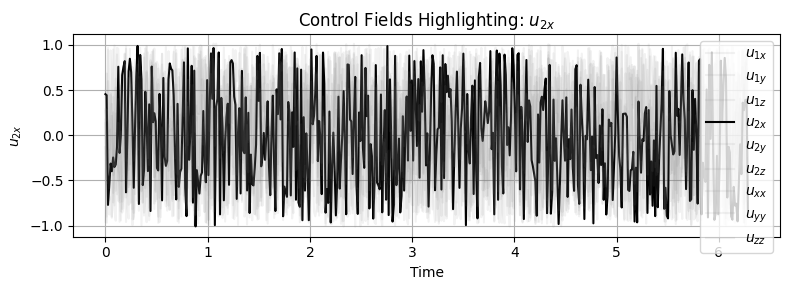

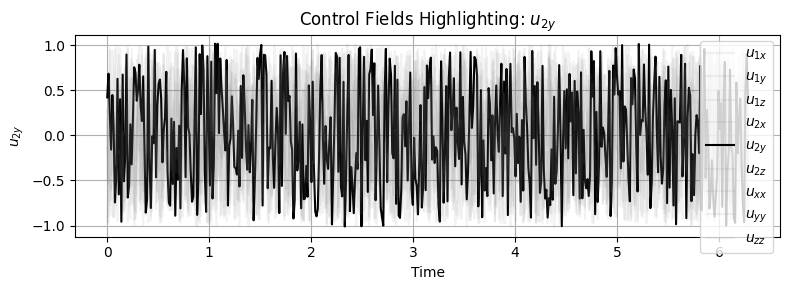

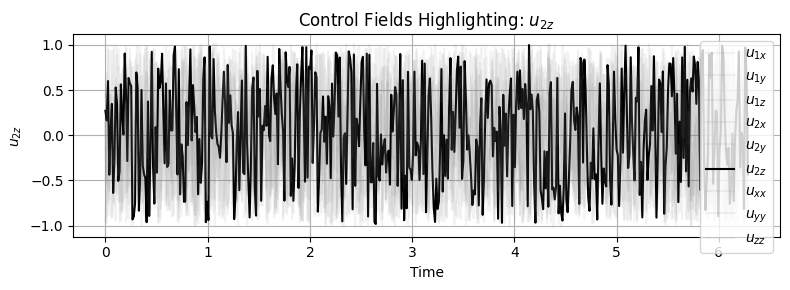

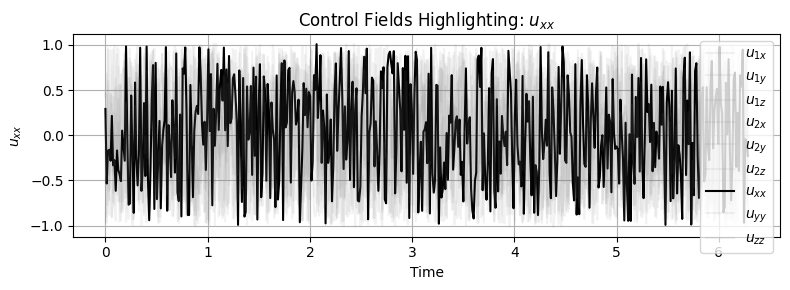

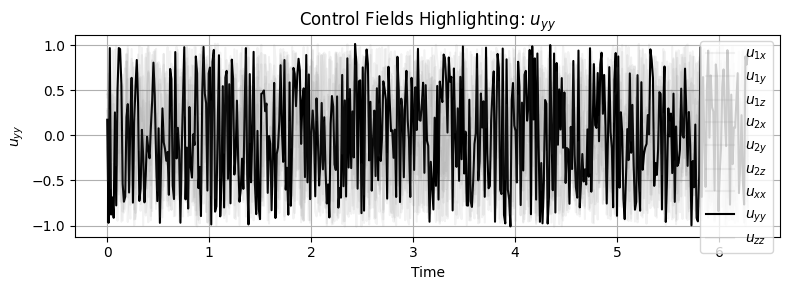

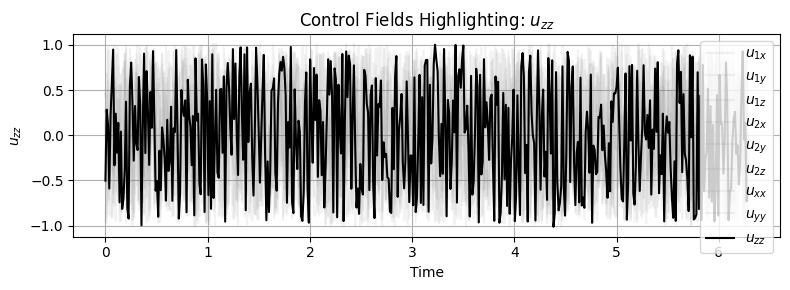

In [7]:
times = jnp.linspace(0, 2 * jnp.pi, 500)
H_labels = [
    r'$u_{1x}$',
    r'$u_{1y}$',
    r'$u_{1z}$',
    r'$u_{2x}$',
    r'$u_{2y}$',
    r'$u_{2z}$',
    r'$u_{xx}$',
    r'$u_{yy}$',
    r'$u_{zz}$',
]
plot_control_amplitudes(
    times, result.control_amplitudes / (2 * jnp.pi), H_labels
)

In [4]:
U_target = cnot()
U_f = result.final_operator

In [5]:
def overlap(U_target, U_f):
    """
    Calculate the overlap between the target unitary U_target and the final unitary U_f.

    Parameters:
    U_target (qutip.Qobj): Target unitary operator.
    U_f (qutip.Qobj): Final unitary operator.

    Returns:
    float: Real part of the overlap value.
    float: Fidelity (absolute square of the overlap).
    """
    # dividing over U_target.shape[0] is for normalization
    overlap_value = (
        jnp.trace(jnp.matmul(U_target.conj().T, U_f)) / U_target.shape[0]
    )
    fidelity = abs(overlap_value) ** 2
    return overlap_value.real, fidelity


# Example usage
overlap_real, fidelity = overlap(U_target, U_f)
print(f"Overlap (real part): {overlap_real}")
print(f"Fidelity: {fidelity}")

Overlap (real part): 0.7071067811845866
Fidelity: 0.999999999994454
